<a href="https://colab.research.google.com/github/giuliaries/MachineLearning/blob/main/Adaboost_on_IRIS_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Giulia Santoiemma](mailto:giulia.santoiemma@studenti.unipd.it) 2004775<br/>
Machine Learning<br/> 
Master Degree in Computer Science<br/>
12 December 2021

In [2]:
# Import libraries
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tabulate import tabulate

import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## The Iris Dataset

This is the [Iris dataset by sklearn](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html).

This data sets consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica) petal and sepal length, stored in a 150x4 numpy.ndarray

The rows being the samples and the columns being: Sepal Length, Sepal Width, Petal Length and Petal Width.

In [3]:
# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

display(pd.DataFrame(data=iris.data, columns=iris.feature_names))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


## Preprocessing

In [4]:
# Scale the data
scaled_features = StandardScaler().fit_transform(X)
scaled_features[:5]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ]])

## Feature Extraction via PCA

I extract the two main components among the four of the Iris dataset.

For more accuracy, I could have classified the examples using all four components, but I use two to be able to visualize the examples and the Adaboost effect via an animation.

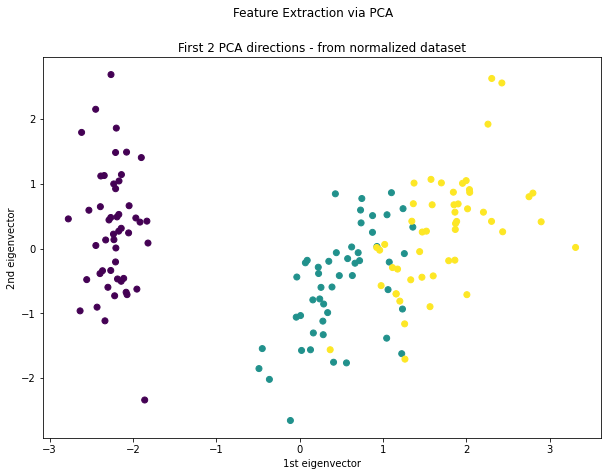

In [5]:
# Extraction of the 2 main components starting from the normalized dataset
pca = PCA(n_components = 2)
pc2 = pca.fit_transform(scaled_features)

# Plot the training points
figure = plt.figure(1, figsize=(10, 7))
figure.suptitle("Feature Extraction via PCA")
ax = figure.add_subplot(111)
ax.scatter(pc2.T[0], pc2.T[1], c=y)
ax.set_title("First 2 PCA directions - from normalized dataset")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")

plt.show()

## AdaBoosted Decision Tree

In [6]:
# Split the datasets into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(pc2, y, test_size=0.3)

headers = [" AdaBoosted\n Decision Tree"]
report = [["# Estimators"], ["𝜶 Accuracy"], ["𝝅 Precision"], ["𝝆 Recall"]]
bdt, bdt_model = {}, {}

for est in range(5, 51, 5):
  # Create and fit an AdaBoosted decision tree
  bdt[est] = AdaBoostClassifier(
      DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=est
  )

  # Fit the current model according to the given training dataset
  bdt_model[est] = bdt[est].fit(X_train, y_train)

  # Predict the classification for the provided data (the test set)
  y_pred = bdt_model[est].predict(X_test)

  headers.append("")
  report[0].append(est)
  report[1].append(accuracy_score(y_test, y_pred))
  report[2].append(precision_score(y_test, y_pred, average="macro"))
  report[3].append(recall_score(y_test, y_pred, average="macro"))

# Show the results for the Neural Network Classifier
print(tabulate(report, headers=headers, tablefmt="rst"))

================  ========  =========  =========  =========  =========  =========  =========  =========  =========  =========
 AdaBoosted
 Decision Tree
================  ========  =========  =========  =========  =========  =========  =========  =========  =========  =========
# Estimators      5         10         15         20         25         30         35         40         45         50
𝜶 Accuracy        0.933333   0.933333   0.933333   0.955556   0.933333   0.977778   0.933333   0.977778   0.933333   0.977778
𝝅 Precision       0.9375     0.9375     0.9375     0.955556   0.9375     0.97619    0.9375     0.97619    0.9375     0.97619
𝝆 Recall          0.9375     0.9375     0.9375     0.958333   0.9375     0.979167   0.9375     0.979167   0.9375     0.979167
================  ========  =========  =========  =========  =========  =========  =========  =========  =========  =========


In [7]:
# Animation
fig, ax = plt.subplots()
plt.rcParams["animation.html"] = "jshtml"
plt.close()

# Plot the decision boundaries
xp = np.arange(pc2[:,0].min()-1, pc2[:,0].max()+1, .02)
yp = np.arange(pc2[:,1].min()-1, pc2[:,1].max()+1, .02)
xx, yy = np.meshgrid(xp, yp)

def animate(i):
  ax.clear()

  # Plot background
  Z = bdt[(i+1)*5].predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  cs = ax.contourf(xx, yy, Z, cmap = plt.cm.Pastel1)

  # Plot the training points
  ax.scatter(pc2[:,0], pc2[:,1], c=y)

animation = matplotlib.animation.FuncAnimation(fig, animate, frames=len(bdt), interval=400)
animation